In [18]:
import feather
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

## Look at what files are available

In [19]:
ls HackTimeSeries/

AD1_2002__Kruess_1__12.feather
AD1_2002__Kruess_1__13.feather
AD1_2002__Kruess_1__14.feather
AD1_2002__Kruess_1__15.feather
AD1_2002__Kruess_1__16.feather
AD1_2002__Kruess_1__17.feather
AD1_2002__Kruess_2__12.feather
AD1_2002__Kruess_2__13.feather
AD1_2002__Kruess_2__14.feather
AD1_2002__Kruess_2__15.feather
AD1_2002__Kruess_2__16.feather
AD1_2002__Kruess_2__17.feather
AD1_2002__Kruess_3__13.feather
AD1_2002__Kruess_3__14.feather
AD1_2002__Kruess_3__15.feather
AD1_2002__Kruess_3__16.feather
AD1_2002__Kruess_3__17.feather
AD1_2002__Kruess_3__18.feather
AD1_2008__Kwaiser_1_Milford_2.feather
AD1_2008__Kwaiser_2_Milford_2.feather
AD1_2011__Richards_1__4.feather
AD1_2011__Richards_1__5.feather
AD1_2011__Richards_1__6.feather
AD1_2011__Richards_2__4.feather
AD1_2011__Richards_2__5.feather
AD1_2011__Richards_2__6.feather
AD1_2011__Richards_3__4.feather
AD1_2011__Richards_3__5.feather
AD1_2011__Richards_3__6.feather
CC1_2004__Clark_1_A_1.feather
CC1_2004__Clark_1_A_10.feather
CC1_2004__Clark_1

VK1_2011__Legare_1_Arbec_44.feather
VK1_2011__Legare_1_Arbec_45.feather
VK1_2011__Legare_1_Arbec_46.feather
VK1_2011__Legare_1_Arbec_47.feather
VK1_2011__Legare_1_Arbec_48.feather
VK1_2011__Legare_1_Arbec_49.feather
VK1_2011__Legare_1_Arbec_50.feather
VK1_2011__Legare_1_Arbec_51.feather
VK1_2011__Legare_1_Arbec_52.feather
VK1_2011__Legare_1_Arbec_53.feather
VK1_2011__Legare_1_Arbec_54.feather
VK1_2011__Legare_1_Arbec_55.feather
VK1_2011__Legare_1_Arbec_56.feather
VK1_2011__Legare_1_Arbec_57.feather
VK1_2011__Legare_1_Arbec_58.feather
VK1_2011__Legare_1_Arbec_59.feather
VK1_2011__Legare_1_Arbec_60.feather
VK1_2011__Legare_1_Kruger_61.feather
VK1_2011__Legare_1_Kruger_62.feather
VK1_2011__Legare_1_Kruger_63.feather
VK1_2011__Legare_1_Kruger_64.feather
VK1_2011__Legare_1_Kruger_65.feather
VK1_2011__Legare_1_Kruger_66.feather
VK1_2011__Legare_1_Kruger_67.feather
VK1_2011__Legare_1_Kruger_68.feather
VK1_2011__Legare_1_Kruger_69.feather
VK1_2011__Legare_1_Kruger_70.feather
VK1_2011__Legare_1

## Read in an example dataframe

In [20]:

df = feather.read_dataframe('HackTimeSeries/AD1_2002__Kruess_1__12.feather')

In [21]:
df

,id,EVI2,NBR,NDMI,NDVI,SS,SSBS,blue,green,nir,...,date,Sat,Predominant_habitat,Longitude,Latitude,Biome,Max_linear_extent,Hansenlossyear,Sample_start_earliest,YearsOfConversion
0,1_1_1_LT41950231988128_2,0.574879,0.591910,0.297979,0.774536,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,0.0447,0.0712,0.4014,...,1988-05-07 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
1,1_1_1_LT41950231990149_2,NaN,NaN,NaN,NaN,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,NaN,NaN,NaN,...,1990-05-29 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
2,1_1_1_LT41950231990181_2,NaN,NaN,NaN,NaN,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,NaN,NaN,NaN,...,1990-06-30 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
3,1_1_1_LT41950231991184_2,0.581790,0.643477,0.358786,0.776373,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,0.0457,0.0703,0.4075,...,1991-07-03 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
4,1_1_1_LT41950231992139_2,0.600801,0.678307,0.338247,0.803930,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,0.0387,0.0622,0.4085,...,1992-05-18 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
5,1_1_1_LT41960221989153_2,NaN,NaN,NaN,NaN,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,NaN,NaN,NaN,...,1989-06-02 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
6,1_1_1_LT41960221990140_2,0.562525,0.629558,0.357131,0.730944,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,0.0589,0.0841,0.4201,...,1990-05-20 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
7,1_1_1_LT41960221990172_2,0.338759,0.745455,0.553398,0.786047,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,0.0373,0.0369,0.1920,...,1990-06-21 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
8,1_1_1_LT41960221990204_2,NaN,NaN,NaN,NaN,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,NaN,NaN,NaN,...,1990-07-23 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0
9,1_1_1_LT41960231988135_2,0.551837,0.615593,0.294688,0.758965,AD1_2002__Kruess 1,AD1_2002__Kruess 1 12,0.0430,0.0654,0.3875,...,1988-05-14 00:00:00+00:00,landsat4tm,Young secondary vegetation,9.756647,53.680467,Temperate Broadleaf & Mixed Forests,0.52,NaN,1996-05-01,1989.0


## Sort by Date and plot

In [22]:
df['Date'] =pd.to_datetime(df.date)

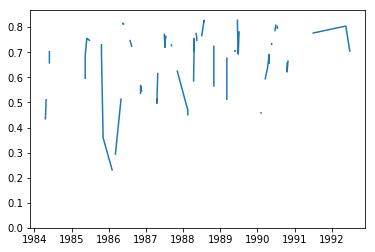

In [23]:
plt.plot(df.sort_values('Date')['Date'],df.sort_values('Date')['NDVI'])

## Convert Datetime to number of days

In [24]:
df['date_delta'] = (df['Date'] - df['Date'].min())  / np.timedelta64(1,'D')

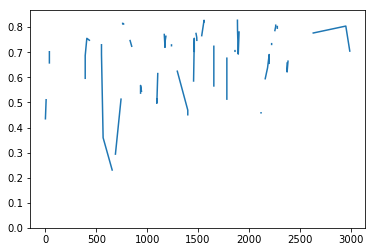

In [25]:
plt.plot(df.sort_values('Date')['date_delta'],df.sort_values('Date')['NDVI'])

## Lets play with GPFlow

In [26]:
import GPflow

Lets use 2 kernels:
1. Perodic exponential Kernel for seasonal variation
2. Squared exponential Kernel for other trend

## First, assign X and Y values by sorting by date, and removing NaNs

In [27]:
X=df.sort_values('Date')['date_delta'].values
Y=df.sort_values('Date')['NDVI'].values
ind_good=np.isfinite(Y)
X=X[ind_good][:,np.newaxis]
Y=Y[ind_good][:,np.newaxis]

In [28]:
k1 = GPflow.kernels.RBF(1)
k2 = GPflow.kernels.PeriodicKernel(1,period=300.0)
m = GPflow.gpr.GPR(X,Y, kern=k1+k2)
m.likelihood.variance = 0.0001

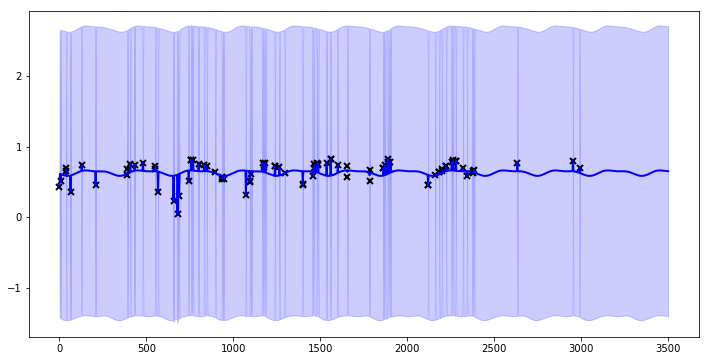

In [29]:
def plot(m):
    xx = np.arange(0, 3500,1,dtype=float)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
plot(m)

Name,values,prior,constraint
name.likelihood.variance,[ 0.00167469],None,+ve
name.kern.rbf.lengthscales,[ 10.44291314],None,+ve
name.kern.rbf.variance,[ 0.00858202],None,+ve
name.kern.periodickernel.variance,[ 0.36401498],None,+ve
name.kern.periodickernel.lengthscales,[ 1.97982875],None,+ve
name.kern.periodickernel.period,[ 357.65670436],None,+ve


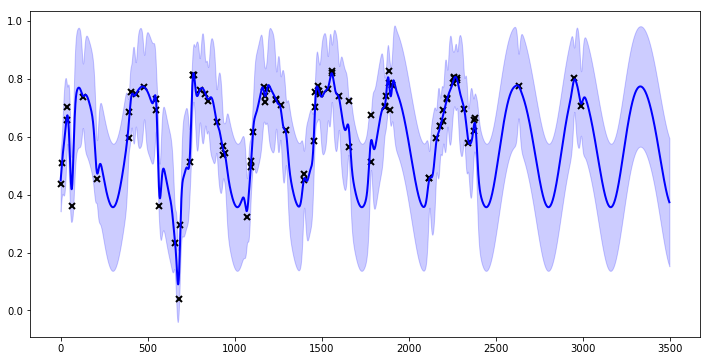

In [30]:
m.optimize(maxiter=10000)
plot(m)
m

## Now I can fit model, use posterior predicitve checks to detect change points

In [17]:
log_pred=np.empty((Y.size))
import scipy.stats as st

for i in range(0,Y.size-1):
    print i
    m = GPflow.gpr.GPR(X[0:i,:],Y[0:i,:], kern=k1+k2)
    m.likelihood.variance = 1.0
    m.optimize(maxiter=10000)
    mean,variance=m.predict_y(X[i+1:i+3,:])
    log_pred[i]=st.norm.ppf(st.norm.cdf(Y[i+1,:], loc=mean, scale=np.sqrt(variance)))[0]


0
1


InvalidArgumentError: Input matrix is not invertible.
	 [[Node: name.build_likelihood/MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](name.build_likelihood/Cholesky, name.build_likelihood/sub)]]

Caused by op u'name.build_likelihood/MatrixTriangularSolve', defined at:
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-fe86be55ac7f>", line 8, in <module>
    m.optimize(maxiter=10000)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/model.py", line 225, in optimize
    return self._optimize_np(method, tol, callback, maxiter, **kw)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/model.py", line 286, in _optimize_np
    self._compile()
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/model.py", line 135, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/gpr.py", line 63, in build_likelihood
    return multivariate_normal(self.Y, m, L)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/densities.py", line 81, in multivariate_normal
    alpha = tf.matrix_triangular_solve(L, d, lower=True)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 469, in matrix_triangular_solve
    name=name)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input matrix is not invertible.
	 [[Node: name.build_likelihood/MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](name.build_likelihood/Cholesky, name.build_likelihood/sub)]]


In [93]:
m.predict_density(X[i+1:i+3],Y[i+1:i+3])

array([[-1.17232831],
       [-1.23473858]])

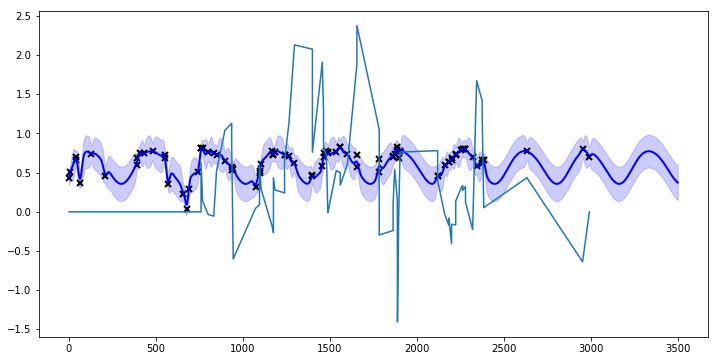

In [26]:
m = GPflow.gpr.GPR(X,Y, kern=k1+k2)
m.likelihood.variance = 0.0001
m.optimize(maxiter=10000)

xx = np.arange(0, 3500,1,dtype=float)[:,None]
mean, var = m.predict_y(xx)
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
plt.plot(X,log_pred)


In [15]:
help(GPflow.kernels.PeriodicKernel)

Help on class PeriodicKernel in module GPflow.kernels:

class PeriodicKernel(Kern)
 |  The periodic kernel. Defined in  Equation (47) of
 |  
 |  D.J.C.MacKay. Introduction to Gaussian processes. In C.M.Bishop, editor,
 |  Neural Networks and Machine Learning, pages 133--165. Springer, 1998.
 |  
 |  Derived using the mapping u=(cos(x), sin(x)) on the inputs.
 |  
 |  Method resolution order:
 |      PeriodicKernel
 |      Kern
 |      GPflow.param.Parameterized
 |      GPflow.param.Parentable
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  K(self, X, X2=None, presliced=False)
 |  
 |  Kdiag(self, X, presliced=False)
 |  
 |  __init__(self, input_dim, period=1.0, variance=1.0, lengthscales=1.0, active_dims=None)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Kern:
 |  
 |  __add__(self, other)
 |  
 |  __mul__(self, other)
 |  
 |  compute_K(instance, *np_args)
 |  
 |  compute_K_symm(instance, *np_args)
 | 